In [1]:
"Importing Libraries"
import numpy as np
import tensorflow as tf
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, LSTM, GRU, Dropout, Input, Layer, SimpleRNN
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import date, timedelta, datetime 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from pandas.plotting import register_matplotlib_converters 
import matplotlib.dates as mdates 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras import Model
import keras.backend as K
import time
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

In [2]:

import os
os.getcwd()
df = pd.read_excel("../Data/BTC Traditional Price Data (16_2_18 - 31_10_20).xlsx")
df = pd.DataFrame.from_records(df)
df.set_index('Date', inplace=True)
for col in df.columns:
    df[col] = df[col].astype('float32')
df.columns

C:\Users\IraniaN\AppData\Local\Temp\ipykernel_13140\3686295340.py:4: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(df)


Index(['Open', 'High', 'Low', 'Close', 'BTC Price', 'Volume'], dtype='object')

In [3]:
train_df = pd.DataFrame(df.copy())
train_df_ext = train_df.copy()
train_df_ext['Prediction'] = train_df_ext['BTC Price']
nrows = train_df.shape[0]
train_data_unscaled = np.array(train_df)
np_data = np.reshape(train_data_unscaled, (nrows, -1))
print("Train Data Set Shape: ", np_data.shape)

#Scaling
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data_unscaled)
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(train_df_ext['BTC Price'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

#Partitioning
sequence_length = 14
index_Close = train_df_ext.columns.get_loc("BTC Price")
train_data_len = math.ceil(train_data_scaled.shape[0] * 0.85)
train_data = train_data_scaled[0:train_data_len, :]
test_data = train_data_scaled[train_data_len - sequence_length:, :]

def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) 
        y.append(data[i, index_Close])
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

print("X_train and y_train shapes: ", x_train.shape, y_train.shape)
print("x_test and y_test shapes: ", x_test.shape, y_test.shape)



Train Data Set Shape:  (989, 6)
X_train and y_train shapes:  (827, 14, 6) (827,)
x_test and y_test shapes:  (148, 14, 6) (148,)


In [ ]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        e = K.squeeze(e, axis=-1)   
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [14]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dropout, Dense, Input
import time

# تعریف لایه توجه (Attention Layer) سفارشی
class AttentionLayer(layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        # وزن‌ها به ابعاد ویژگی‌های ورودی
        self.W = self.add_weight(name="W", shape=(input_shape[-1], 1), initializer="random_normal")  # (128, 1)
        # بایاس برای هر زمان (time_step)
        self.b = self.add_weight(name="b", shape=(input_shape[1],), initializer="zeros")  # (time_steps,)

    def call(self, x):
        # محاسبه نمرات توجه با tf.matmul
        e = tf.matmul(x, self.W)  # ضرب ماتریسی به ابعاد (batch_size, time_steps, 1)
        e = e + self.b  # اضافه کردن بایاس (اضافه کردن به ابعاد [time_steps,] برای هر زمان)
        alpha = tf.nn.softmax(e, axis=1)  # محاسبه وزن‌ها
        
        # اضافه کردن بعد جدید به شکل (batch_size, time_steps, 1)
        alpha = tf.expand_dims(alpha, axis=-1)
        
        return alpha

# مدل شما
model_input = Input(shape=(x_train.shape[1], x_train.shape[2]))

# لایه GRU اول
x = GRU(128, return_sequences=True, activation='tanh')(model_input)

# لایه توجه (Attention)
attention_layer = AttentionLayer()(x)

# اعمال وزن‌های توجه به خروجی GRU
x = layers.multiply([x, attention_layer])  # وزن‌دهی خروجی GRU بر اساس وزن‌های توجه

# اگر ابعاد ورودی GRU دوم (x) درست نباشد، از reshape استفاده کنیم
x = layers.Reshape((-1, 128))(x)  # به ابعاد صحیح تبدیل می‌شود (batch_size, time_steps, features)

# Dropout و GRU دوم
x = Dropout(0.3)(x)
x = GRU(128, return_sequences=False, activation='tanh')(x)

# Dropout و لایه نهایی Dense
x = Dropout(0.3)(x)
x = Dense(1)(x)

# تعریف مدل
model = Model(model_input, x)

# تنظیمات مدل
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='mean_squared_error')

# شروع تایم
start_time = time.time()

# تنظیمات آموزش
epochs = 600
batch_size = 64
early_stop = EarlyStopping(monitor='val_loss', mode="min", patience=40, verbose=1)

# آموزش مدل
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[early_stop],
                    validation_split=0.2,
                    shuffle=False,
                   )

# پیش‌بینی
y_pred_scaled = model.predict(x_test)

print("--- %s seconds ---" % (time.time() - start_time))


Epoch 1/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - loss: 0.1651 - val_loss: 0.2089
Epoch 2/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 350ms/step - loss: 0.1389 - val_loss: 0.1742
Epoch 3/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - loss: 0.1142 - val_loss: 0.1386
Epoch 4/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 327ms/step - loss: 0.0882 - val_loss: 0.1010
Epoch 5/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - loss: 0.0619 - val_loss: 0.0626
Epoch 6/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 292ms/step - loss: 0.0371 - val_loss: 0.0290
Epoch 7/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - loss: 0.0198 - val_loss: 0.0100
Epoch 8/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 309ms/step - loss: 0.0148 - val_loss: 0.0064
Epoch 9/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - loss: 0.0144 - val_loss: 0.0062
Epoch 10/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - loss: 0.0127 - val_loss: 0.0065
Epoch 11/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 295ms/step - loss: 0.0109 - val_loss: 0.0062
Epoch 12/600
11/11 ━━━━━━━━━━━━━━━━━━━━ 

In [15]:
# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

r2 = r2_score(y_test_unscaled, y_pred)
print(f'R2: {np.round(r2, 4)}')

MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)}')



R2: 0.9385
Median Absolute Error (MAE): 207.8000030517578
Mean Absolute Percentage Error (MAPE): 1.89


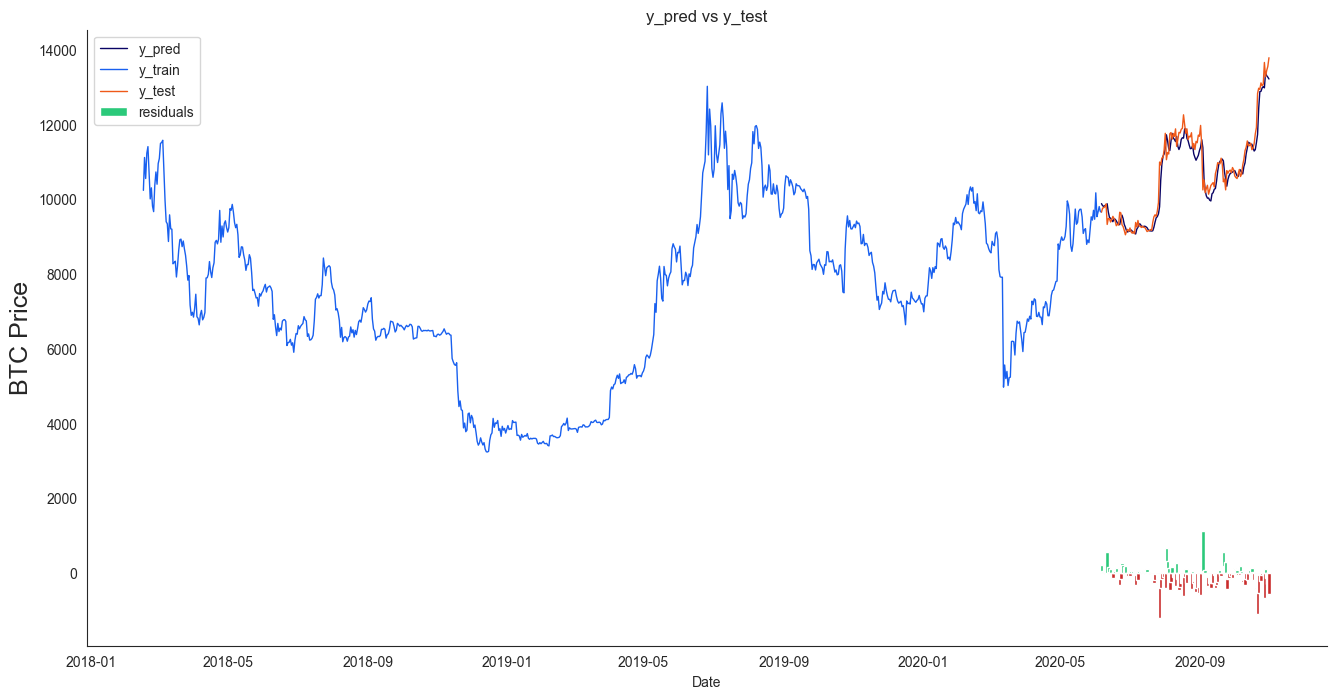

In [16]:
display_start_date = "2018-01-01" 

# Add the difference between the valid and predicted prices
train = pd.DataFrame(train_df_ext['BTC Price'][:train_data_len + 1]).rename(columns={'BTC Price': 'y_train'})
valid = pd.DataFrame(train_df_ext['BTC Price'][train_data_len:]).rename(columns={'BTC Price': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel("BTC Price", fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)

plt.legend()
plt.show()
